In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
import uuid
import itertools
import copy
import math
from PIL import Image
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Useful functions

In [3]:
def als_solve(A, B):
    return torch.linalg.lstsq(A, B).solution
def unfold(tensor, mode):
    """
    Unfolds an n-th order tensor along the specified mode.
    
    Args:
        tensor (torch.Tensor): Input tensor of shape (d0, d1, ..., dn)
        mode (int): Mode along which to unfold (0-based)
        
    Returns:
        torch.Tensor: The mode-i unfolding of shape (tensor.size(mode), -1)
    """
    # Move the mode to the first dimension
    new_order = [mode] + [i for i in range(tensor.ndim) if i != mode]
    permuted = tensor.permute(new_order)
    
    # Flatten all dimensions except the first (which is mode)
    unfolded = permuted.reshape(tensor.shape[mode], -1)
    return unfolded
def fold(unfolded, mode, shape):
    """
    Refolds a matrix back into a tensor of given shape along a mode.
    
    Args:
        unfolded (torch.Tensor): Unfolded matrix of shape (shape[mode], -1)
        mode (int): Mode along which it was unfolded (0-based)
        shape (tuple): Original shape of the tensor before unfolding
        
    Returns:
        torch.Tensor: The refolded tensor of shape `shape`
    """
    # Calculate the shape after permuting mode to front
    new_order = [mode] + [i for i in range(len(shape)) if i != mode]
    inverse_order = list(torch.argsort(torch.tensor(new_order)))

    # Compute the shape of the permuted tensor
    permuted_shape = (shape[mode], -1)
    reshaped = unfolded.reshape([shape[mode]] + [shape[i] for i in range(len(shape)) if i != mode])

    # Invert the permutation to get original order
    folded = reshaped.permute(*inverse_order)
    return folded
def unfold_to_matrix(x: torch.Tensor, dims_to_rows: list[int]) -> torch.Tensor:
    """
    Unfolds a tensor into a matrix, flattening `dims_to_rows` into rows,
    and the rest into columns.

    Args:
        x (torch.Tensor): The input tensor.
        dims_to_rows (list[int]): Dimensions to flatten into the row axis.

    Returns:
        torch.Tensor: A 2D tensor (matrix) of shape (prod(dims_to_rows), prod(other_dims)).
    """
    all_dims = list(range(x.ndim))
    dims_to_cols = [d for d in all_dims if d not in dims_to_rows]

    # Permute to bring row dims first, then col dims
    permuted_dims = dims_to_rows + dims_to_cols
    x_permuted = x.permute(permuted_dims)

    # Compute new shape
    row_size = int(torch.prod(torch.tensor([x.shape[d] for d in dims_to_rows])))
    col_size = int(torch.prod(torch.tensor([x.shape[d] for d in dims_to_cols])))

    return x_permuted.reshape(row_size, col_size)
def get_inverse_perm(p):
    r = []
    for i in range(len(p)):
        # Busquem i en p, la seva pos s'afegeix a r
        for j in range(len(p)):
            if p[j] == i:
                r.append(j)
                break
    return r
def find_permutation(X, Y):
    """
    Returns a list of indices such that applying this permutation to X results in Y.
    Works with unhashable elements.
    """
    if len(X) != len(Y):
        raise ValueError("X and Y must be of the same length.")

    used = [False] * len(Y)
    permutation = []

    for x in X:
        found = False
        for i, y in enumerate(Y):
            if not used[i] and x == y:
                permutation.append(i)
                used[i] = True
                found = True
                break
        if not found:
            raise ValueError("Y is not a permutation of X.")

    return permutation

In [4]:
t = torch.randn(2,2,2,2)
print(t)
print(unfold_to_matrix(t, [1,2]))

print(find_permutation([1,2,3,4], [4,2,1,3]))

tensor([[[[-0.6894, -0.6031],
          [ 0.8649,  0.1409]],

         [[-0.2178,  0.6621],
          [-0.5826, -1.0953]]],


        [[[ 0.9350, -0.7693],
          [ 0.1483,  0.1703]],

         [[-0.2432,  0.8287],
          [-0.2097, -1.5824]]]])
tensor([[-0.6894, -0.6031,  0.9350, -0.7693],
        [ 0.8649,  0.1409,  0.1483,  0.1703],
        [-0.2178,  0.6621, -0.2432,  0.8287],
        [-0.5826, -1.0953, -0.2097, -1.5824]])
[2, 1, 3, 0]


# TN Class

In [5]:
class TN():
    def initTensor(self, shape):
        return torch.randn(shape, device=device)
    def __init__(self, G, sizes, ranks):
        if len(G.edges) != len(ranks):
            raise Exception("Rank length must be equal to the number of edges")
        if len(G.nodes) != len(sizes):
            raise Exception("Sizes length must be equal to the number of nodes")
        self.data = {}
        self.tensors = {}
        # Init data
        i = 0
        for node in G.nodes:
            self.data[node] = [ [sizes[i], -1, i] ]
            i += 1
        i = 0
        for e in G.edges:
            node1, node2 = (e[0], e[1])
            h = uuid.uuid4()
            self.data[node1] += [  [ranks[i], h] ]
            self.data[node2] += [  [ranks[i], h]  ]
            i += 1
        i = 0
        for node in G.nodes:
            shape = []
            for x in self.data[node]:
                shape.append(x[0])
            self.tensors[node] = self.initTensor(shape)
            i += 1
        # print(self.data)
        # print(self.tensors)
    def set_core(self, tensor, node):
        self.tensors[node] = tensor
    def get_core(self, node):
        return self.tensors[node]
    def get_tn_size(self):
        s = 0
        for k in self.tensors.keys():
            s += torch.numel(self.tensors[k])
        return s
    def contract(self, node1, node2, newnode):
        # Compute other indexes
        dim1 = []
        dim2 = []
        for i in range(len(self.data[node1])):
            for j in range(len(self.data[node2])):
                if self.data[node1][i][1] == -1 or self.data[node2][j][1] == -1:
                    continue
                if self.data[node1][i][1] == self.data[node2][j][1]:
                    dim1.append(i)
                    dim2.append(j)
        # print(dim1)
        # print(dim2)
        ts = []
        for i in range(len(self.data[node1])):
            if i not in dim1:
                ts.append(self.data[node1][i])
        for i in range(len(self.data[node2])):
            if i not in dim2:
                ts.append(self.data[node2][i])
        # Compute
        t = torch.tensordot(self.tensors[node1], self.tensors[node2], dims=(dim1, dim2))
        self.data[newnode] = ts
        self.tensors[newnode] = t

        del self.data[node1]
        del self.data[node2]
        del self.tensors[node1]
        del self.tensors[node2]

        # print()
        # print(self.data)
        # for x in self.tensors.keys():
        #    print(self.tensors[x].shape)
    @staticmethod
    def eval(t):
        tn = copy.deepcopy(t)
        p = len(tn.data) + 1
        while len(tn.data) > 1:
            klist = list(tn.data.keys())
            x = klist[0]
            y = klist[1]
            tn.contract(x, y, p)
            p += 1
        # TODO: Fer reshape al return ja que les dims estàn cambiades!
        perm = [[y[2] for y in tn.data[p-1]].index(x) for x in range(len(tn.data[p-1]))]
        return torch.permute(tn.tensors[p-1], perm)

    @staticmethod
    def same_eval(t):
        tn = copy.deepcopy(t)
        p = len(tn.data) + 1
        while len(tn.data) > 1:
            klist = list(tn.data.keys())
            x = klist[-1]
            y = klist[-2]
            tn.contract(x, y, p)
            p += 1
        # TODO: Fer reshape al return ja que les dims estàn cambiades!
        perm = [[y[2] for y in tn.data[p-1]].index(x) for x in range(len(tn.data[p-1]))]
        return torch.permute(tn.tensors[p-1], perm)
    
    @staticmethod
    def get_contraction_except(tn, core):
        t = copy.deepcopy(tn)
        p = len(t.data) + 1
        while len(t.data) > 2:
            klist = list(t.data.keys())
            e = [klist[0], klist[1], klist[2]]
            if core in e:
                e.remove(core)
            
            x = e[0]
            y = e[1]
            
            t.contract(x, y, p)
            p += 1
        tens = t.tensors[p-1]
        # print(tens.shape)
        tnn = copy.deepcopy(t)
        tnn.contract(p-1, core, p)
        # print("Tensor:")
        # print(tnn.tensors[p])
        
        return (t.tensors[p-1], t.tensors[core], t.data[p-1], t.data[core])
    
    @staticmethod
    def als(tn, t, err, iter_num=float('inf'), print_iters=False):
        iters = 0
        rel_err = torch.norm(TN.eval(tn) - t).item() / torch.norm(t).item()
        while rel_err >= err:
            rel_err = torch.norm(TN.eval(tn) - t).item() / torch.norm(t).item()
            # print(torch.norm(TN.eval(tn) - t))
            if print_iters:
                print("epoch " + str(iters+1) + "/" + str(iter_num) + " err: " + str(rel_err))
            if iters > iter_num:
                break
            for k in range(1, len(tn.tensors) + 1):
                #print("----")
                # Aqui hem de fer el reshape
                cont_ten, orig_ten, cont_data, orig_data = TN.get_contraction_except(tn, k)

                #print("Orig:")
                #print(cont_ten.shape)
                #print(orig_ten.shape)
                #print(cont_data)
                #print(orig_data)
                #print("--------------")

                uuid_order = []
                for x in orig_data:
                    if x[1] != -1:
                        uuid_order.append(x[1])

                # Volem una permutació que deixi en uuid_order els edges de cont_ten
                perm = [-1] * len(cont_ten.shape)
                tperm = []
                i = 0
                nx = 1
                for j in range(len(cont_data)):
                    if cont_data[j][1] == -1:
                        perm[j] = i
                        tperm.append(cont_data[j][2])
                        i += 1
                        nx *= cont_data[j][0]
                ny = 1
                for u in uuid_order:
                    for j in range(len(cont_data)):
                        if cont_data[j][1] == u:
                            perm[j] = i
                            i += 1
                            ny *= cont_data[j][0]
                tperm.append(orig_data[0][2])
                # Tenim la permutació a perm
                # I tperm es la permutació que cal de modificar el tensor objectiu
                cont_perm = torch.permute(cont_ten, get_inverse_perm(perm))
                # I podem fer ja la matriu

                #print("Cont properties:")
                #print(get_inverse_perm(perm))
                #print(cont_perm.shape)
                cont_mat = torch.reshape(cont_perm, (nx, ny))
                #print(cont_mat.shape)

                # Permutem ojectiu
                t_obj = torch.permute(t, tperm)

                #print("Perm shapes:")
                #print(cont_perm.shape)
                #print(t_obj.shape)
                # I fem reshape!

                # print(cont_perm.shape)
                # print(t_obj.shape)

                obj_mat = torch.reshape(t_obj, (nx, orig_data[0][0]))

                #print(cont_mat.shape)
                #print(obj_mat.shape)

                core = torch.linalg.lstsq(cont_mat, obj_mat)[0]

                #print("HUH")
                #print(torch.dist(cont_mat @ core, obj_mat))
                #print(torch.dist(core, torch.linalg.pinv(cont_mat) @ obj_mat))

                # print(core.shape)
                # print(core.shape)
                # print(orig_ten.shape)

                # Ara busquem el core
                shape = orig_ten.shape
                shape_left = shape[1:] + shape[:1]

                #print(orig_ten.shape)
                res_core = torch.reshape(core, shape_left)
                #print("La shape es:")
                #print(res_core.shape)
                res_core = res_core.permute(res_core.ndim - 1, *range(0, res_core.ndim - 1))

                # A partir d'aqui son comprovacions de que ho estic fent bé
                #print(res_core.shape)
                #print(cont_ten.shape)

                

                #comp_tn = copy.deepcopy(tn)
                #comp_tn.tensors = {2: res_core, 1: cont_ten}
                #comp_tn.data = {2: orig_data, 1: cont_data}
                #resul = TN.eval(comp_tn)
                #print("WHAAAAAAAT")
                #print(torch.dist(resul, t))
                
                


                # print(res_core.shape)
                

                tn.set_core(res_core, k)
            iters += 1
            #return
        # print("Done")

In [6]:
a = torch.randn(1,2,3,4,5)
print(a.flip([4,3,2,1,0]).shape)

torch.Size([1, 2, 3, 4, 5])


# Tests

In [7]:
G = nx.Graph()
G.add_node(1)
G.add_node(2)


# nx.draw(G, with_labels=True)
# plt.show()

# tn = TN(G, [3, 3], [])
# print(tn.tensors)
# print(TN.eval(tn))

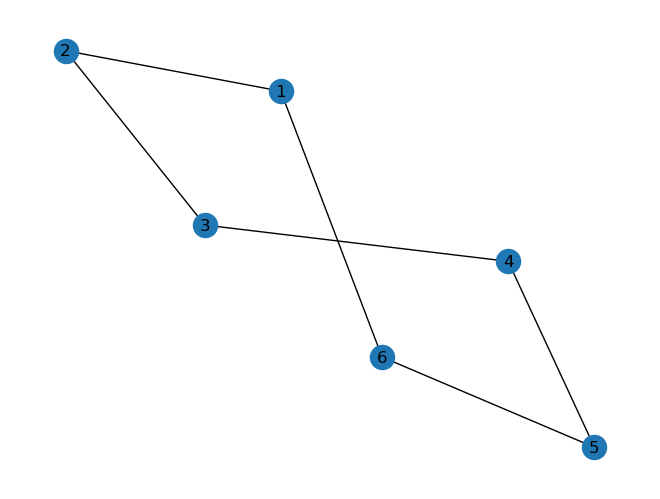

Original: 4096
Tensor Network: 2400
Rel error: 0.45382857214689926


In [8]:
G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6,1)])
nx.draw(G, with_labels=True)
plt.show()

objective = torch.randn(4,4,4,4,4,4, device=device)

ntn = TN(G, [4,4,4,4,4,4], [10,10,10,10,10,10])
TN.als(ntn, objective, 1e-3, iter_num=100)

# print(TN.eval(tn))
err = torch.norm(objective - TN.eval(ntn)).item()
rel_err = err / torch.norm(objective).item()

print("Original: " + str(torch.numel(objective)))
print("Tensor Network: " + str(ntn.get_tn_size()))
print("Rel error: " + str(rel_err))

In [9]:
def search_ranks(t, G, max_rank=10, min_rank=3):
    for r_list in itertools.product(list(range(min_rank, max_rank)), repeat=len(G.edges)):
        if sum(r_list) <= min_rank:
            continue
        if math.prod(r_list) > torch.numel(t):
            continue
    
        ntn = TN(G, list(t.shape), r_list)
        TN.als(ntn, objective, 1e-3, iter_num=100)

        err = torch.norm(t - TN.eval(ntn)).item()
        rel_err = err / torch.norm(t).item()

        print(str(r_list) + " => " + str(rel_err))

        

torch.Size([4, 262, 492])


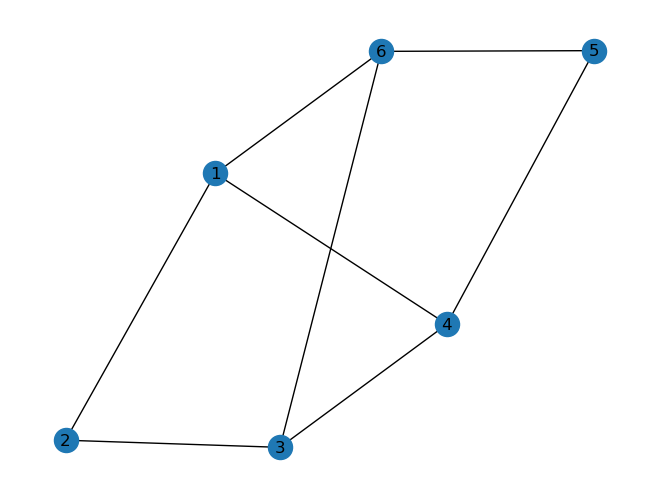

Original: 515616
Tensor Network: 2400
epoch 1/20 err: 7244.217956857411


KeyboardInterrupt: 

In [10]:
# Load image using PIL
image = Image.open('doradito.png')  # Replace with your image path

# Define transformation: convert image to tensor
transform = transforms.ToTensor()
device = "cpu"

# Apply transformation
image_tensor = transform(image)

# Optional: check shape
print(image_tensor.shape)  # (C, H, W)
objective = image_tensor.reshape(4, 2, 131, 4, 3, 41).to(device)

G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 6), (1, 4)])

nx.draw(G, with_labels=True)
plt.show()

print("Original: " + str(torch.numel(objective)))
print("Tensor Network: " + str(ntn.get_tn_size()))

ntn = TN(G, list(objective.shape), [9, 9,12,9, 9,12, 8, 4])
TN.als(ntn, objective, 1e-3, iter_num=20, print_iters=True)

In [ ]:
# If image_tensor is (C, H, W), convert to (H, W, C)
image_np = image_tensor.permute(1, 2, 0).numpy()
# Show image
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
# If image_tensor is (C, H, W), convert to (H, W, C)
image_np = TN.eval(ntn).reshape(image_tensor.shape).permute(1, 2, 0).numpy()


# Show image
plt.imshow(image_np)
plt.axis('off')
plt.show()